## Grupo

227124 Jorge Henrique Monteiro dos Santos

262251 Vitor Mello de Araujo Lima

## Objetivo

Aplicar os vários regressores visto em aula. Busca de hiperparametros.


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from statistics import mean
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
import numpy as np

# Leia

## Leia o arquivo ouro2.csv.


In [19]:
url = "https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/ouro2.csv"
data = pd.read_csv(url, parse_dates=True, index_col = "Data")
data = data[::-1]
data.shape

(1096, 1)

In [20]:
data[::]

,Valor
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-02-07,283.2
2000-09-07,281.1
2000-07-16,280.1
...,...
2021-05-16,1878.9
2021-05-23,1905.3
2021-05-30,1892.0


<AxesSubplot:xlabel='Data'>

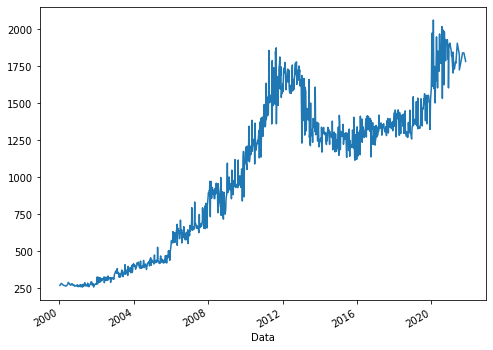

In [21]:
data['Valor'].plot(figsize=(8,6))

# Centering and Normalizing

Não há necessidade de fazer normalização, pois os dados possuem a mesma unidade. Logo não há casos de operações entre dados com unidades ou magnitudes diferentes. 

In [22]:
test_data = data[-100:]
train_data = data[:-100]



train_data.shape

(996, 1)

In [23]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.hstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    return lag_array

In [24]:
lst = [x if x < 8 else x-16 for x in range(16)]

train_data.iloc[lst, :]

,Valor
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-02-07,283.2
2000-09-07,281.1
2000-07-16,280.1
2000-07-23,277.7
2000-07-30,272.6
2000-06-08,275.1
2019-05-26,1349.6


In [25]:

train_data

,Valor
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-02-07,283.2
2000-09-07,281.1
2000-07-16,280.1
...,...
2019-06-16,1432.7
2019-06-23,1446.8
2019-06-30,1436.6


In [26]:
window_size = 4
# X train do not use last value, there's no future value to be predicted
x_train = get_lagged_features(train_data, window_size, 1)


y_train =  train_data.values[4:]
y_train_timestamps = train_data.index[:4]


check_data = df(x_train)
check_data["Y"] = y_train

y_train_change = df(check_data['Y'].values - check_data[window_size-1].values)
check_data["Y-change"] = y_train_change


assert ( all ( (check_data['Y'][:-1].values) - (check_data['Y'][1:].values) == -check_data['Y-change'][1:].values) ) #quick test


check_data[::]

,0,1,2,3,Y,Y-change
0,282.7,290.1,283.2,281.1,280.1,-1.0
1,290.1,283.2,281.1,280.1,277.7,-2.4
2,283.2,281.1,280.1,277.7,272.6,-5.1
3,281.1,280.1,277.7,272.6,275.1,2.5
4,280.1,277.7,272.6,275.1,276.8,1.7
...,...,...,...,...,...,...
987,1330.1,1349.6,1381.9,1381.5,1432.7,51.2
988,1349.6,1381.9,1381.5,1432.7,1446.8,14.1
989,1381.9,1381.5,1432.7,1446.8,1436.6,-10.2
990,1381.5,1432.7,1446.8,1436.6,1450.9,14.3


In [27]:
tmp_y_train_change = y_train - (np.array([x_train[:,window_size-1]]).T)

cmp_change = y_train[1:] - y_train[:-1]

assert all ((tmp_y_train_change[1:] == cmp_change))

In [28]:
from sklearn.linear_model import LinearRegression

tscv = TimeSeriesSplit(n_splits = 5)

for train_index, test_index in tscv.split(x_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]

tscv_same_size = TimeSeriesSplit(n_splits = 5, max_train_size=165)
for train_index, test_index in tscv_same_size.split(x_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)



TRAIN: (167,) TEST: (165,)
TRAIN: (332,) TEST: (165,)
TRAIN: (497,) TEST: (165,)
TRAIN: (662,) TEST: (165,)
TRAIN: (827,) TEST: (165,)
TRAIN: (165,) TEST: (165,)
TRAIN: (165,) TEST: (165,)
TRAIN: (165,) TEST: (165,)
TRAIN: (165,) TEST: (165,)
TRAIN: (165,) TEST: (165,)


In [29]:
lin = LinearRegression()
default_rmes = cross_val_score(lin, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', verbose=0)

print(-mean(default_rmes))

26.269651547551618


In [30]:
from sklearn.model_selection import RandomizedSearchCV

def evaluate_regressor (X, y, regressor, params, cross_validator, n_it=10,scorer='neg_root_mean_squared_error'):

    
    rnd_search = RandomizedSearchCV(regressor(), 
                                    params, 
                                    n_iter = n_it, 
                                    cv=cross_validator, 
                                    scoring=scorer,
                                    n_jobs=12)
    rnd_search.fit(X, y)

    return rnd_search.best_score_,  rnd_search.best_params_


def get_lagged_data(df,window_size):
    x_data = get_lagged_features(df, window_size, 1)
    
    y_shifted = df.shift(1)
    y_change = (df > y_shifted).astype(int)
    y_data = y_change[window_size:].values
    y_data = y_data.ravel()
    
    return x_data,y_data

In [31]:
# Test function with Linear Regression

rmse, params = evaluate_regressor(x_train, y_train, LinearRegression, {}, tscv, 1)

print(rmse, params)

-26.269651547551614 {}


In [32]:
# Test with L2 Regulator
from sklearn.linear_model import Ridge
from sklearn.utils.fixes import loguniform

parameters = {
    'alpha': loguniform(10**-3, 10**3)
    }

rmse, params = evaluate_regressor(X=x_train,
                                  y=y_train, 
                                  regressor=Ridge, 
                                  params   =parameters, 
                                  cross_validator = tscv, 
                                  n_it=10)
print(rmse, params)

-26.26965164674622 {'alpha': 0.0028543900202641173}


In [33]:
# Generate all regressors and parameters
import pprint
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

test_model_r = {

    'Linear Regression': {
        'regressor' : LinearRegression,
        'parameters': {},
        'n_iter'    : 1,
        'results'   : {}
    },
    'Ridge': {
        'regressor': Ridge,
        'parameters': {
            'alpha': loguniform(10**-6, 10**6),
            'max_iter': [2000]
        },
        'n_iter'    : 100,
        'results' : {}
    },
    'Lasso': {
        'regressor': Lasso,
        'parameters': {
            'alpha': loguniform(10**-6, 10**6),
            'max_iter': [5000]
        },
        'n_iter' : 100,
        'results' : {}
    },
    'SVM Linear':{
        'regressor': SVR,
        'parameters': {
            'C'      : loguniform(2**-5, 2**15),
            'epsilon': [0.01,0.1,0.2,0.3,0.4],
            'kernel' : ['linear'],
            'max_iter': [5000]
            },
        'n_iter' : 100,
        'results' : {}
    },
    'SVM RBF':{
        'regressor': SVR,
        'parameters': {
            'C'      : loguniform(2**-10, 2**20),
            'epsilon': [0.01,0.1,0.2,0.3,0.4],
            'gamma'  : loguniform(2**-12, 2**6),
            'kernel' : ['rbf'],
            'max_iter': [5000]
            },
        'n_iter' : 100,
        'results' : {}
    },
    'K-Nearest Neighbors': {
        'regressor': KNeighborsRegressor,
        'parameters': {
            'n_neighbors': stats.randint(1,1000)
            },
        'n_iter' : 100,
        'results' : {} 
    },
    'Multi-layer Perceptron': {
        'regressor': MLPRegressor,
        'parameters': {
            'hidden_layer_sizes': np.arange(5, 29+1, 3),
            'max_iter': [5000]
            },
        'n_iter' : 9,
        'results' : {} 
    },
    'Decision Tree': {
        'regressor': DecisionTreeRegressor,
        'parameters': {
            'ccp_alpha': uniform(loc=0.0, scale=0.04)
            },
        'n_iter' : 100,
        'results' : {} 
    },
    'Random Forest': {
        'regressor': RandomForestRegressor,
        'parameters': {
            'n_estimators': [10, 30, 100, 300, 1000],
            'max_features': ['auto', 'sqrt', 'log2']
            },
        'n_iter' : 15,
        'results' : {} 
    },
    'Gradient Boost Machine': {
        'regressor': GradientBoostingRegressor,
        'parameters': {
            'n_estimators': np.arange(5, 101, 1),
            'learning_rate': uniform(loc=0.01, scale=(0.3-0.01)),
            'max_depth': [2,3,4,5]
            },
        'n_iter' : 100,
        'results' : {} 
    }
}






In [34]:
for w_size in [1,2,3,4,5,10,15,20,50]:

    x_train = get_lagged_features(train_data, w_size, 1)
    
    y_train = train_data.values[w_size:]

    #Subtract Y from the most recent column from x
    y_train_change = y_train - (np.array([x_train[:,w_size-1]]).T)
    cmp_change = y_train[1:] - y_train[:-1]
    assert all ((y_train_change[1:] == cmp_change)) #quick test
   
    for regressor in test_model_r.keys():
        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train, 
                                            regressor=test_model_r[regressor]['regressor'], 
                                            params   =test_model_r[regressor]['parameters'], 
                                            cross_validator = tscv, 
                                            n_it     =test_model_r[regressor]['n_iter'])
        
        
        test_model_r[regressor]['results'][str(w_size)]               = {}                                    
        test_model_r[regressor]['results'][str(w_size)]['y-absolute'] = {}
        test_model_r[regressor]['results'][str(w_size)]['y-absolute']['unequal_size'] = {}

        test_model_r[regressor]['results'][str(w_size)]['y-absolute']['unequal_size']['RMSE']    = -rmse
        test_model_r[regressor]['results'][str(w_size)]['y-absolute']['unequal_size']['hparams'] = params

        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train, 
                                            regressor=test_model_r[regressor]['regressor'], 
                                            params   =test_model_r[regressor]['parameters'], 
                                            cross_validator = tscv_same_size, 
                                            n_it     =test_model_r[regressor]['n_iter'])
        
        test_model_r[regressor]['results'][str(w_size)]['y-absolute']['same_size'] = {}

        test_model_r[regressor]['results'][str(w_size)]['y-absolute']['same_size']['RMSE']    = -rmse
        test_model_r[regressor]['results'][str(w_size)]['y-absolute']['same_size']['hparams'] = params
        
        
        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train_change, 
                                            regressor=test_model_r[regressor]['regressor'], 
                                            params   =test_model_r[regressor]['parameters'], 
                                            cross_validator = tscv, 
                                            n_it     =test_model_r[regressor]['n_iter'])
        
        test_model_r[regressor]['results'][str(w_size)]['y-change'] = {}
        test_model_r[regressor]['results'][str(w_size)]['y-change']['unequal_size'] = {}
        
        test_model_r[regressor]['results'][str(w_size)]['y-change']['unequal_size']['RMSE']    = -rmse
        test_model_r[regressor]['results'][str(w_size)]['y-change']['unequal_size']['hparams'] = params

        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train_change, 
                                            regressor=test_model_r[regressor]['regressor'], 
                                            params   =test_model_r[regressor]['parameters'], 
                                            cross_validator = tscv_same_size, 
                                            n_it     =test_model_r[regressor]['n_iter'])
        
        test_model_r[regressor]['results'][str(w_size)]['y-change']['same_size'] = {}
        
        test_model_r[regressor]['results'][str(w_size)]['y-change']['same_size']['RMSE']    = -rmse
        test_model_r[regressor]['results'][str(w_size)]['y-change']['same_size']['hparams'] = params


   nan -307.88539333           nan           nan -239.08740882
           nan           nan           nan           nan -327.12084193
           nan           nan           nan -248.98132811           nan
           nan -274.27839103           nan           nan           nan
           nan           nan           nan           nan           nan
 -239.08740882           nan           nan           nan           nan
           nan           nan           nan -307.03649777           nan
           nan           nan           nan           nan -211.80499015
           nan           nan           nan           nan           nan
           nan -318.78968253           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan -269.00152184           nan           nan
           nan           nan           nan -263.35998256           nan
 -279.85515467           nan -329.38074137           nan -239.08740882]
  warnings.wa

In [36]:
pprint.pprint(test_model_r)

psilon': 0.01,
                                                                        'gamma': 0.000259640188692954,
                                                                        'kernel': 'rbf',
                                                                        'max_iter': 5000}},
                                              'unequal_size': {'RMSE': 281.3674575748803,
                                                               'hparams': {'C': 388.5254177522861,
                                                                           'epsilon': 0.4,
                                                                           'gamma': 0.00033075945183986004,
                                                                           'kernel': 'rbf',
                                                                           'max_iter': 5000}}},
                               'y-change': {'same_size': {'RMSE': 26.285599498254857,
                                       

In [37]:

%%capture cap
pprint.pprint(test_model_r)
with open('test_model_absolute_change_sizes.txt', 'w') as f:
    pprint.pprint(test_model_r, stream=f)

# Classificação 

In [38]:
# Generate all classifiers and parameters
import pprint
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


test_model_c = {

    'Logistic Regression': {
        'regressor' : LogisticRegression,
        'parameters': {'max_iter': [2000]},
        'n_iter'    : 1,
        'results'   : {}
    },
    'Logistic Regression - L1': {
        'regressor': LogisticRegression,
        'parameters': {
            'penalty': ['l1'],
            'C' : loguniform(2**-5, 2**15),
            'solver' : ['saga'],
            'max_iter': [2000]
        },
        'n_iter'    : 10,
        'results' : {}
    },
    'Logistic Regression - L2': {
        'regressor': LogisticRegression,
        'parameters': {
            'penalty': ['l2'],
            'C' : loguniform(2**-5, 2**15),
            'max_iter': [2000]
        },
        'n_iter' : 10,
        'results' : {}
    },
    'Linear Discriminant Analysisr':{
        'regressor': LinearDiscriminantAnalysis,
        'parameters': {},
        'n_iter'    : 1,
        'results'   : {}
    },
    'Quadratic Discriminant Analysis':{
        'regressor': QuadraticDiscriminantAnalysis,
        'parameters': {},
        'n_iter'    : 1,
        'results'   : {}
    },
    'K-Nearest Neighbors': {
        'regressor': KNeighborsClassifier,
        'parameters': {
            'n_neighbors': stats.randint(1,20)
            },
        'n_iter' : 10,
        'results' : {} 
    },
    'SVM Linear': {
        'regressor': SVC,
        'parameters': {
            'C'      : loguniform(2**-5, 2**15),
            'kernel' : ['linear']
        },
        'n_iter' : 10,
        'results' : {} 
    },
    'SVM RBF': {
        'regressor': SVC,
        'parameters': {
            'C'      : loguniform(2**-5, 2**15),
            'gamma'  : loguniform(2**-9, 2**3),
            'kernel' : ['rbf']
        },
        'n_iter' : 10,
        'results' : {} 
    },
    'Multi-layer Perceptron': {
        'regressor': MLPClassifier,
        'parameters': {
            'hidden_layer_sizes': np.arange(5, 29+1, 3),
            'max_iter': [5000]
            },
        'n_iter' : 10,
        'results' : {} 
    },
    'Decision Tree': {
        'regressor': DecisionTreeClassifier,
        'parameters': {
            'ccp_alpha': uniform(loc=0.0, scale=0.04)
            },
        'n_iter' : 10,
        'results' : {} 
    },
    'Random Forest': {
        'regressor': RandomForestClassifier,
        'parameters': {
            'n_estimators': [10, 30, 100, 300, 1000],
            'max_features': ['auto', 'sqrt', 'log2']
            },
        'n_iter' : 15,
        'results' : {} 
    },
    'Gradient Boost Machine': {
        'regressor': GradientBoostingClassifier,
        'parameters': {
            'n_estimators': np.arange(5, 101, 1),
            'learning_rate': uniform(loc=0.01, scale=(0.3-0.01)),
            'max_depth': [2,3,4,5]
            },
        'n_iter' : 10,
        'results' : {} 
    },
    'Gaussian Naive Bayes': {
        'regressor': GaussianNB,
        'parameters': {},
        'n_iter'    : 1,
        'results'   : {} 
    }
}

In [39]:
tscv = TimeSeriesSplit(n_splits = 5)
tscv_same_size = TimeSeriesSplit(n_splits = 5, max_train_size=165)

def evaluate_classifier (X, y, regressor, params, cross_validator, n_it=10):

    
    rnd_search = RandomizedSearchCV(regressor(), 
                                    params, 
                                    n_iter = n_it, 
                                    cv=cross_validator,
                                    n_jobs=12)
    rnd_search.fit(X, y)

    return rnd_search.best_score_,  rnd_search.best_params_


for w_size in [1,2,3,4,5,10,15,20,50]:
   
    x_train, y_train = get_lagged_data(train_data,w_size) 

    for regressor in test_model_c.keys():
        acc, params = evaluate_classifier(  X=x_train,
                                            y=y_train, 
                                            regressor=test_model_c[regressor]['regressor'], 
                                            params   =test_model_c[regressor]['parameters'], 
                                            cross_validator = tscv, 
                                            n_it     =test_model_c[regressor]['n_iter'])
        
        
        test_model_c[regressor]['results'][str(w_size)]               = {}                                    
        test_model_c[regressor]['results'][str(w_size)]['y-absolute'] = {}
        test_model_c[regressor]['results'][str(w_size)]['y-absolute']['unequal_size'] = {}

        test_model_c[regressor]['results'][str(w_size)]['y-absolute']['unequal_size']['accuracy']    = acc
        test_model_c[regressor]['results'][str(w_size)]['y-absolute']['unequal_size']['hparams'] = params

        rmse, params = evaluate_classifier(  X=x_train,
                                            y=y_train, 
                                            regressor=test_model_c[regressor]['regressor'], 
                                            params   =test_model_c[regressor]['parameters'], 
                                            cross_validator = tscv_same_size, 
                                            n_it     =test_model_c[regressor]['n_iter'])
        
        test_model_c[regressor]['results'][str(w_size)]['y-absolute']['same_size'] = {}

        test_model_c[regressor]['results'][str(w_size)]['y-absolute']['same_size']['accuracy']    = acc
        test_model_c[regressor]['results'][str(w_size)]['y-absolute']['same_size']['hparams'] = params

/home/vmello/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/vmello/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/vmello/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/vmello/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/vmello/min

In [43]:
%%capture cap
with open('test_model_claffifiers_absolute_change_sizes.txt', 'w') as f:
    pprint.pprint(test_model_c, stream=f)

In [231]:
best_score = {
    'y-absolute': 1000,
    'y-change' : 1000
}

best_algorithm = {
    'best_regressor':{
        'y-absolute': { 'result':{} },
        'y-change'  : { 'result':{} }
    },
    'best_classifier': {'result' : {}}
}

for regressor in test_model_r.keys():
    for w_size in [1,2,3,4,5,10,15,20,50]:
        for y in ['y-absolute', 'y-change']:
            for test_set_size in ['same_size', 'unequal_size']:
                if test_model_r[regressor]['results'][str(w_size)][y][test_set_size]['RMSE'] < best_score[y] :
                    best_score[y] = test_model_r[regressor]['results'][str(w_size)][y][test_set_size]['RMSE']
                    best_algorithm['best_regressor'][y]["name"] = regressor
                    best_algorithm['best_regressor'][y]["test_set_size"] = test_set_size
                    best_algorithm['best_regressor'][y]["window_size"]   = w_size
                    best_algorithm['best_regressor'][y]['result'] = test_model_r[regressor]['results'][str(w_size)][y][test_set_size]

best_score_c=0
for regressor in test_model_c.keys():
    for w_size in [1,2,3,4,5,10,15,20,50]:
        for y in ['y-absolute']:
            for test_set_size in ['same_size', 'unequal_size']:
                if test_model_c[regressor]['results'][str(w_size)][y][test_set_size]['accuracy'] > best_score_c :
                    best_score_c = test_model_c[regressor]['results'][str(w_size)][y][test_set_size]['accuracy']
                    best_algorithm['best_classifier']["name"] = regressor
                    best_algorithm['best_classifier']["test_set_size"] = test_set_size
                    best_algorithm['best_classifier']["window_size"]   = w_size
                    best_algorithm['best_classifier']['result'] = test_model_c[regressor]['results'][str(w_size)][y][test_set_size]

pprint.pprint(best_algorithm)

{'best_classifier': {'name': 'Multi-layer Perceptron',
                     'result': {'accuracy': 0.5806060606060606,
                                'hparams': {'hidden_layer_sizes': 8,
                                            'max_iter': 5000}},
                     'test_set_size': 'same_size',
                     'window_size': 3},
 'best_regressor': {'y-absolute': {'name': 'Linear Regression',
                                   'result': {'RMSE': 26.093312173180614,
                                              'hparams': {}},
                                   'test_set_size': 'unequal_size',
                                   'window_size': 1},
                    'y-change': {'name': 'SVM RBF',
                                 'result': {'RMSE': 26.0616610680878,
                                            'hparams': {'C': 12283.472727566028,
                                                        'epsilon': 0.01,
                                                        'ga

In [318]:
%%capture cap
with open('best_algorithms.txt', 'w') as f:
    pprint.pprint(best_algorithm, stream=f)

RMES:  44.07618252459717 B1:  [[0.9484813]] B0:  [93.76679106]


<AxesSubplot:>

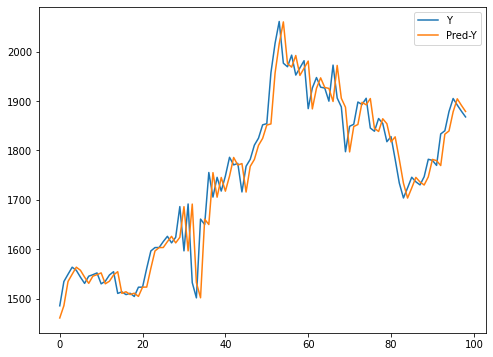

In [261]:
from sklearn.metrics import mean_squared_error
# Test with the final data

# Best absolute
regr = test_model_r[ best_algorithm['best_regressor']['y-absolute']['name'] ]['regressor']

assert regr == LinearRegression

x_train = get_lagged_features(train_data,int(best_algorithm['best_regressor']['y-absolute']['window_size']), 1)
x_test  = get_lagged_features(test_data, int(best_algorithm['best_regressor']['y-absolute']['window_size']), 1)

y_train = train_data.values[int(best_algorithm['best_regressor']['y-absolute']['window_size']):]
y_test =  test_data.values[ int(best_algorithm['best_regressor']['y-absolute']['window_size']):]

display_test_data = df(x_test, columns=["X"])
display_test_data["Y"] = y_test
display_test_data

r_abs_pred_x = regr().fit(x_train, y_train).predict(x_test)

 
best_algorithm['best_regressor']['y-absolute']['RMES final'] = mean_squared_error(y_test, r_abs_pred_x, squared=False)

print('RMES: ', best_algorithm['best_regressor']['y-absolute']['RMES final'], 'B1: ', regr().fit(x_test, y_test).coef_, 'B0: ', regr().fit(x_test, y_test).intercept_)
display_test_data['Pred-Y'] = r_abs_pred_x
display_test_data.drop(['X'], axis=1).plot(figsize=(8,6))






Best with Y-Change is , RMES:  SVM RBF 44.30918086966307
/home/vmello/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


<AxesSubplot:>

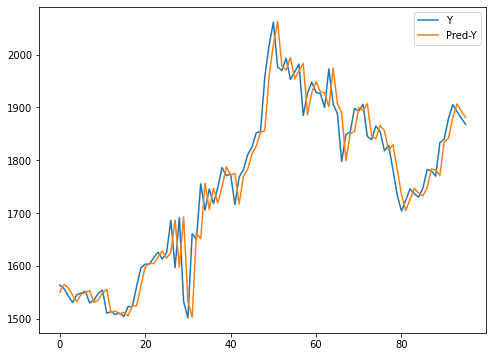

In [278]:
# Best with Y-change

regr = test_model_r[ best_algorithm['best_regressor']['y-change']['name'] ][ 'regressor' ]

window_size = int(best_algorithm['best_regressor']['y-change']['window_size'])
x_test  = get_lagged_features(test_data,  window_size, 1)
x_train = get_lagged_features(train_data, window_size, 1)

y_test  = test_data.values[ window_size:]
y_train = train_data.values[window_size:]

y_train_minus_1 = np.array([x_train[:,window_size-1]]).T
y_train_change  = y_train - y_train_minus_1

r_chg = regr().set_params( **best_algorithm['best_regressor']['y-change']['result']['hparams'] ).fit(x_train, np.ravel(y_train_change))

y_change_pred = r_chg.predict(x_test)

y_test_minus_1 = np.array([x_test[:,window_size-1]]).T

assert all (y_test_minus_1[1:] == y_test[:-1])

y_pred = np.ravel(y_test_minus_1) + y_change_pred


best_algorithm['best_regressor']['y-change']['RMES final'] = mean_squared_error(y_test, y_pred, squared=False)

print("Best with Y-Change is , RMES: ", best_algorithm['best_regressor']['y-change']['name'], best_algorithm['best_regressor']['y-change']['RMES final'])

display_test_data = df(y_test, columns=['Y'])
display_test_data['Pred-Y'] = y_pred
display_test_data.plot(figsize=(8,6))




In [316]:
# Best classifier
window_size = int(best_algorithm['best_classifier']['window_size'])

x_train, y_train = get_lagged_data(train_data, window_size) 
x_test,  y_test  = get_lagged_data(test_data,  window_size) 

params = best_algorithm['best_classifier']['result']['hparams']
regr = test_model_c[ best_algorithm['best_classifier']['name'] ][ 'regressor' ]

r = regr().set_params(**params).fit(x_train, y_train)
acc = r.score(x_test,y_test)

best_algorithm['best_classifier']['final accuracy'] = acc

print("Best with Y-Change is ", best_algorithm['best_classifier']['name'], ", Accuracy: ", best_algorithm['best_classifier']['final accuracy'])




Best with Y-Change is  Multi-layer Perceptron , Accuracy:  0.5670103092783505


In [317]:
pprint.pprint(best_algorithm)

{'best_classifier': {'final accuracy': 0.5670103092783505,
                     'name': 'Multi-layer Perceptron',
                     'result': {'accuracy': 0.5806060606060606,
                                'hparams': {'hidden_layer_sizes': 8,
                                            'max_iter': 5000}},
                     'test_set_size': 'same_size',
                     'window_size': 3},
 'best_regressor': {'y-absolute': {'RMES final': 44.07618252459717,
                                   'name': 'Linear Regression',
                                   'result': {'RMSE': 26.093312173180614,
                                              'hparams': {}},
                                   'test_set_size': 'unequal_size',
                                   'window_size': 1},
                    'y-change': {'RMES final': 44.30918086966307,
                                 'name': 'SVM RBF',
                                 'result': {'RMSE': 26.0616610680878,
                    

In [344]:
# Create regressor table

reg_results_dict = {}

for regressor in test_model_r.keys():
    reg_results_dict[regressor] = {'Best RMES':1000}
    for w_size in [1,2,3,4,5,10,15,20,50]:
        for y in ['y-absolute', 'y-change']:
            for test_set_size in ['same_size', 'unequal_size']:
                if test_model_r[regressor]['results'][str(w_size)][y][test_set_size]['RMSE'] < reg_results_dict[regressor]['Best RMES'] :
                    reg_results_dict[regressor]['Best RMES'] = test_model_r[regressor]['results'][str(w_size)][y][test_set_size]['RMSE']
                    reg_results_dict[regressor]['hparams'] = test_model_r[regressor]['results'][str(w_size)][y][test_set_size]['hparams']

                    tmp  = False
                    for k in reg_results_dict[regressor]['hparams']:
                        if k == 'max_iter':
                            tmp=True
                            break
                    if tmp:
                        del reg_results_dict[regressor]['hparams']['max_iter']


                    reg_results_dict[regressor]['window size'] = w_size
                    reg_results_dict[regressor]['test set size'] = test_set_size
                    reg_results_dict[regressor]['Y'] = y

pprint.pprint (reg_results_dict)


{'Decision Tree': {'Best RMES': 35.2244634530899,
                   'Y': 'y-change',
                   'hparams': {'ccp_alpha': 0.01978626435026498},
                   'test set size': 'same_size',
                   'window size': 50},
 'Gradient Boost Machine': {'Best RMES': 26.2812014973447,
                            'Y': 'y-change',
                            'hparams': {'learning_rate': 0.012779751915195552,
                                        'max_depth': 2,
                                        'n_estimators': 6},
                            'test set size': 'same_size',
                            'window size': 2},
 'K-Nearest Neighbors': {'Best RMES': 26.14152909519737,
                         'Y': 'y-change',
                         'hparams': {'n_neighbors': 163},
                         'test set size': 'same_size',
                         'window size': 2},
 'Lasso': {'Best RMES': 26.086048996755448,
           'Y': 'y-change',
           'hparams': {'alph

In [343]:
cls_results_dict = {}

for regressor in test_model_c.keys():
    cls_results_dict[regressor] = {'Best Accuracy':0}
    for w_size in [1,2,3,4,5,10,15,20,50]:
        for y in ['y-absolute']:
            for test_set_size in ['same_size', 'unequal_size']:
                if test_model_c[regressor]['results'][str(w_size)][y][test_set_size]['accuracy'] > cls_results_dict[regressor]['Best Accuracy'] :
                    cls_results_dict[regressor]['Best Accuracy'] = test_model_c[regressor]['results'][str(w_size)][y][test_set_size]['accuracy']
                    cls_results_dict[regressor]['hparams']       = test_model_c[regressor]['results'][str(w_size)][y][test_set_size]['hparams']
                    
                    tmp  = False
                    for k in cls_results_dict[regressor]['hparams']:
                        if k == 'max_iter':
                            tmp=True
                            break
                    if tmp:
                        del cls_results_dict[regressor]['hparams']['max_iter']

                    cls_results_dict[regressor]['window size']   = w_size
                    cls_results_dict[regressor]['test set size'] = test_set_size

cls_results_dict

{'Logistic Regression': {'Best Accuracy': 0.5636363636363636,
  'hparams': {},
  'window size': 1,
  'test set size': 'same_size'},
 'Logistic Regression - L1': {'Best Accuracy': 0.5636363636363636,
  'hparams': {'C': 0.8570005741088372, 'penalty': 'l1', 'solver': 'saga'},
  'window size': 1,
  'test set size': 'same_size'},
 'Logistic Regression - L2': {'Best Accuracy': 0.5636363636363636,
  'hparams': {'C': 21.720903376262893, 'penalty': 'l2'},
  'window size': 1,
  'test set size': 'same_size'},
 'Linear Discriminant Analysisr': {'Best Accuracy': 0.547878787878788,
  'hparams': {},
  'window size': 3,
  'test set size': 'same_size'},
 'Quadratic Discriminant Analysis': {'Best Accuracy': 0.5345454545454544,
  'hparams': {},
  'window size': 1,
  'test set size': 'same_size'},
 'K-Nearest Neighbors': {'Best Accuracy': 0.5395061728395062,
  'hparams': {'n_neighbors': 9},
  'window size': 20,
  'test set size': 'same_size'},
 'SVM Linear': {'Best Accuracy': 0.5648484848484848,
  'hparam

In [362]:
reg_table = df.from_dict(reg_results_dict, orient='index').drop('hparams', axis=1)




In [367]:
%%capture cap
print(cls_table.to_latex())
with open('output.txt', 'w') as f:
    f.write(cap.stdout)

In [368]:
cls_table = df.from_dict(cls_results_dict, orient='index').drop('hparams', axis=1)
cls_table

,Best Accuracy,window size,test set size
Logistic Regression,0.563636,1,same_size
Logistic Regression - L1,0.563636,1,same_size
Logistic Regression - L2,0.563636,1,same_size
Linear Discriminant Analysisr,0.547879,3,same_size
Quadratic Discriminant Analysis,0.534545,1,same_size
K-Nearest Neighbors,0.539506,20,same_size
SVM Linear,0.564848,4,same_size
SVM RBF,0.568153,50,same_size
Multi-layer Perceptron,0.580606,3,same_size
Decision Tree,0.568153,50,same_size
